In [1]:
from plantcv import plantcv as pcv
import numpy as np
import matplotlib
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

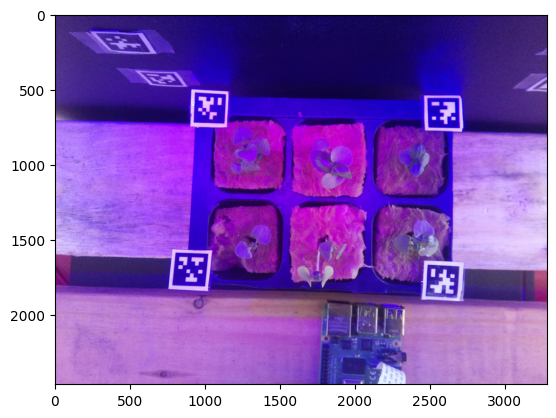

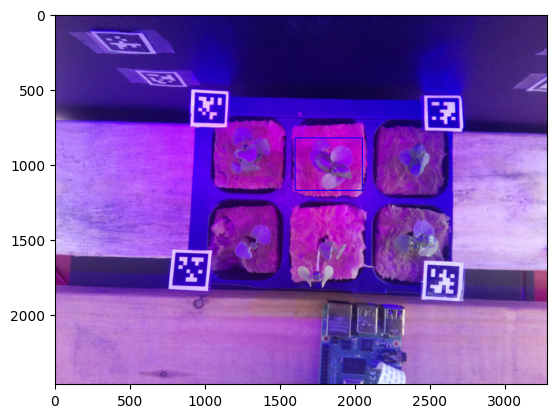

In [2]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
assert base_url
im_helper = ImageHelper(base_url)
dt_str = '3/12/2022 14:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))
img, path, filename = pcv.readimage(im_helper.image.name)
crop_img = pcv.crop(img=img, x=1600, y=825, h=350, w=450)

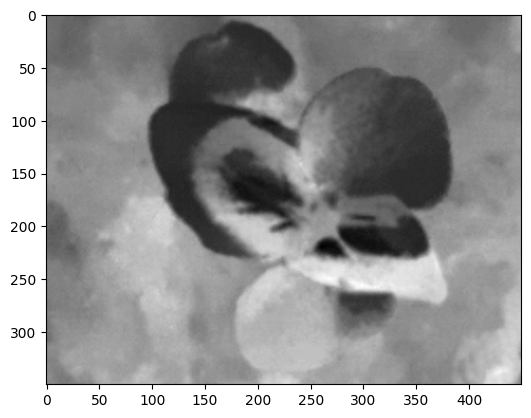

In [3]:
a = pcv.rgb2gray_lab(rgb_img=crop_img, channel='b')

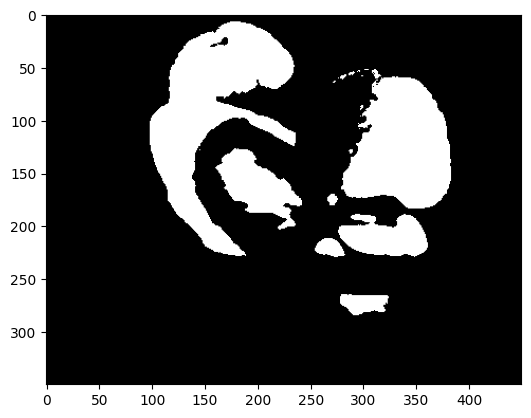

In [4]:
a_thresh = pcv.threshold.binary(gray_img=a, threshold=60, max_value=255, object_type='dark')

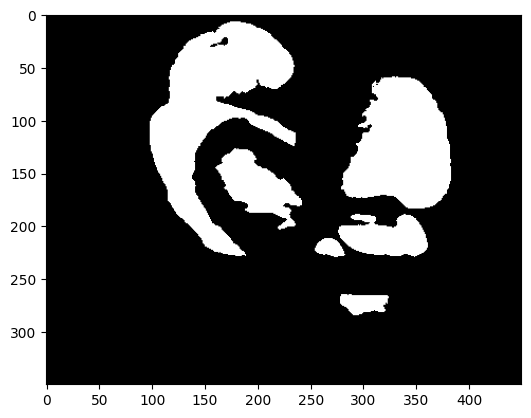

In [5]:
# Inputs:
#   bin_img = Binary image data
#   size    = minimum object area size in pixels (integer), smaller objects will be filled
a_fill = pcv.fill(bin_img=a_thresh, size=200)

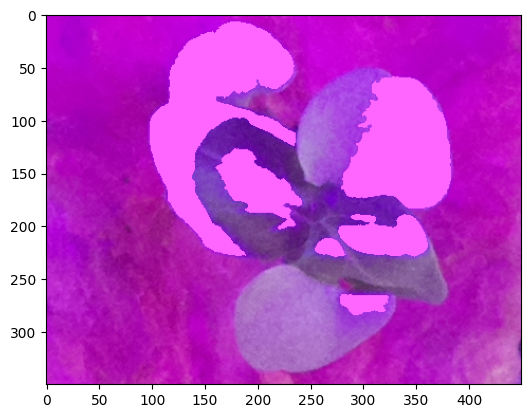

In [6]:
# Inputs:
#   img  = input image
#   mask = a binary mask used to detect objects
obj, obj_hierarchy = pcv.find_objects(img=crop_img, mask=a_fill)

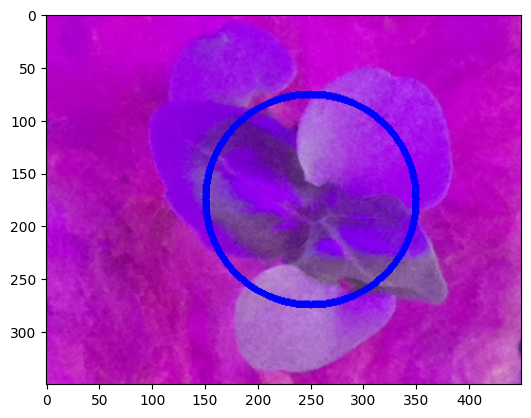

In [7]:
# Inputs:
#   img     = input image
#   coord   = top left coordinate to begin the ROI grid
#   radius  = radius for each ROI
#   spacing = spacing between each ROI
#   nrows   = number of rows in the ROI grid
#   ncols   = number of columns in the ROI grid
rois, roi_hierarchy = pcv.roi.multi(img=crop_img, coord=(250,175), radius=100, 
                                    spacing=(450, 500), nrows=1, ncols=1)



In [8]:
# Inputs:
#   start = beginning value for range
#   stop  = ending value for range (exclusive)
plant_ids = range(0, len(rois))

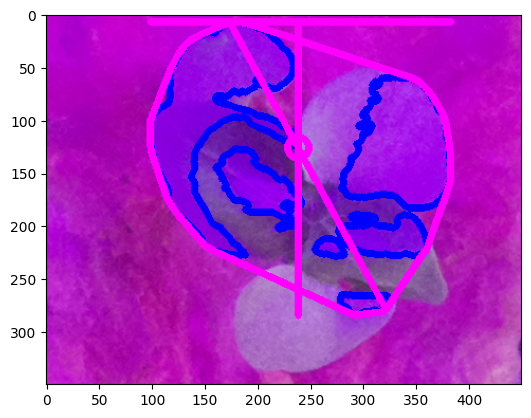

In [9]:
# Create a copy of the original image for annotations

# Inputs:
#   img = rgb image
img_copy = np.copy(crop_img)

# Set debug to None (plotting all of the images would be very verbose output)
pcv.params.debug = None

# Create a for loop to interate through every ROI (plant) in the image
for i in range(0, len(rois)):
    # The ith ROI, ROI hierarchy, and plant ID
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    plant_id = plant_ids[i]
    # Subset objects that overlap the ROI
    # Inputs:
    #   img            = input image
    #   roi_contour    = a single ROI contour
    #   roi_hierarchy  = a single ROI hierarchy
    #   object_contour = all objects detected in a binary mask
    #   obj_hierarchy  = all object hierarchies
    #   roi_type       = "partial" (default) keeps contours that overlap
    #                    or are contained in the ROI. "cutto" cuts off
    #                    contours that fall outside the ROI. "largest"
    #                    only keeps the largest object within the ROI
    plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=crop_img, 
                                                                  roi_contour=roi, 
                                                                  roi_hierarchy=hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")

# If the plant area is zero then no plant was detected for the ROI
    # and no measurements can be done
    if area > 0:
        # Combine contours together for each plant
        # Inputs:
        #   img       = input image
        #   contours  = contours that will be consolidated into a single object
        #   hierarchy = the relationship between contours
        plant_obj, plant_mask = pcv.object_composition(img=crop_img, 
                                                       contours=plant_contours, 
                                                       hierarchy=plant_hierarchy)        
        # Analyze the shape of each plant
        # Inputs:
        #   img   = input image
        #   obj   = composed object contours
        #   mask  = binary mask that contours were derived from
        #   label = a label for the group of measurements (default = "default")
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      mask=plant_mask, label=f"plant{plant_id}")

pcv.plot_image(img_copy)

In [ ]:
#Top View
#get pixel area of each plant
plant_area = pcv.outputs.observations[f"plant{plant_id[0]}"]['pixel_area']['value']
#get center of mass of each plant
plant_com = pcv.outputs.observations[f"plant{plant_id[0]}"]['center_of_mass']['value']
#find pixel distance from center of mass to front of carton

#Side view
#draw a line across the image at carton height
#get center of mass of each plant
plant_com = pcv.outputs.observations[f"plant{plant_id[0]}"]['center_of_mass']['value']
#find pixel height from line ot center of mass for each plant 

#Putting it together
#get camera instrinsics 
K = np.matrix([[971.646825, 0.000000, 501.846472], 
                    [0.000000, 972.962863, 402.829241], 
                    [0.000000, 0.000000, 1.000000]])
#use measured distance to dirt on top view to get the real life distance from side camera to plants
#use the calculated distance to the plants to get the height of the plants in side view
#use the height of the plants to get the real life area of the plants in top view
#output height and area 
    